In [245]:
import duckdb
import pandas as pd
import numpy as np

In [263]:
db = duckdb.connect("sensor.db")
df = db.execute("select * from measurements").fetch_df()
db.close()

In [264]:
# https://github.com/mack-raymond/Exploring-Data-Acquisition-with-Android-Devices-and-Python/tree/master
# https://medium.com/analytics-vidhya/exploring-data-acquisition-and-trajectory-tracking-with-android-devices-and-python-9fdef38f25ee
from scipy.integrate import cumulative_trapezoid
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')

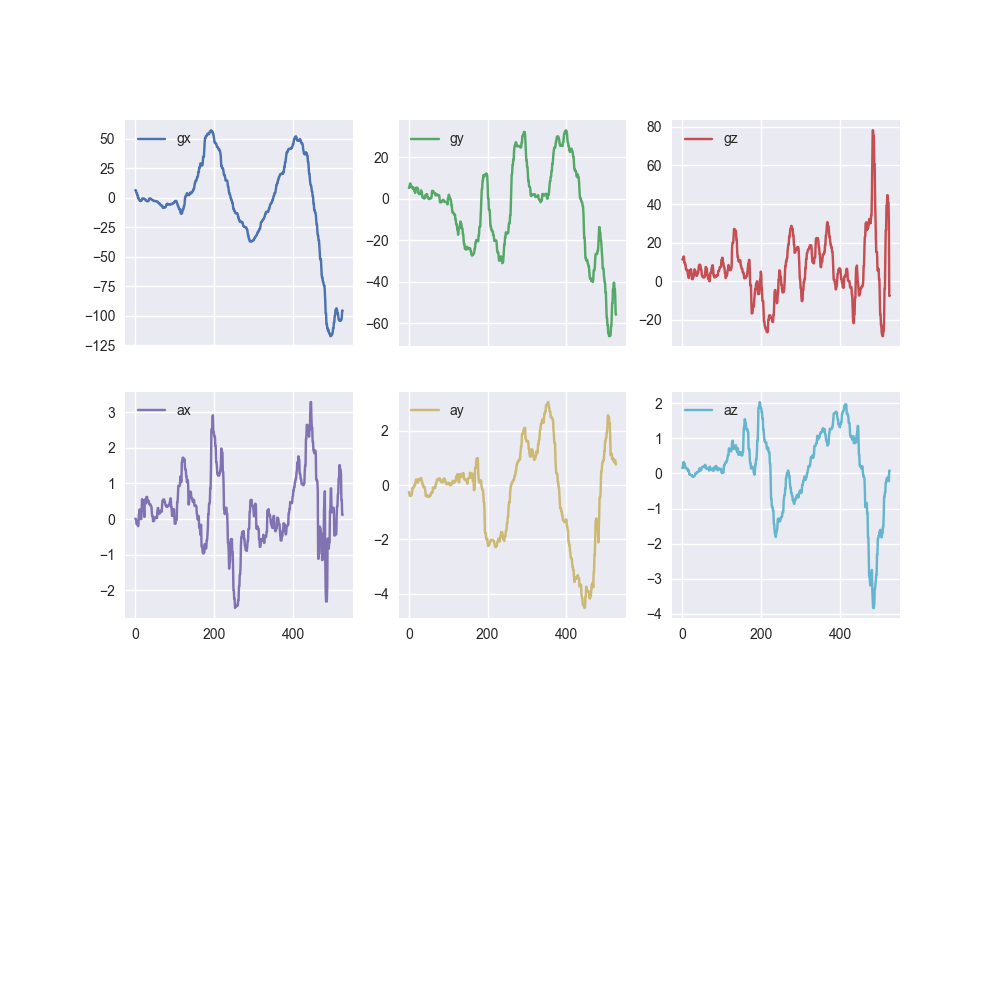

In [265]:
# plot gyro and acceleration
df.drop('clock', axis=1).plot(subplots=True, sharex=True, layout=(3,3), figsize=(10, 10))
plt.show()

In [269]:
# Transform body frame accelerations into the inertial (Earth) frame
# Set up rotation matrices
def R_x(x):
    # body frame rotation about x-axis
    return np.array([[1,      0,       0],
                     [0,cos(-x),-sin(-x)],
                     [0,sin(-x), cos(-x)]])
def R_y(y):
    # body frame rotation about y-axis
    return np.array([[cos(-y),0,-sin(-y)],
                    [0,      1,        0],
                    [sin(-y), 0, cos(-y)]])
def R_z(z):
    # body frame rotation about z axis
    return np.array([[cos(-z),-sin(-z),0],
                     [sin(-z), cos(-z),0],
                     [0,      0,       1]])

# roll = x, pitch = y, yaw = z, converted to radians
roll = df['gx']
pitch = df['gy']
yaw = df['gz']

accel = np.array([df['ax'], df['ay'], df['az']])
earth_accel = np.empty(accel.shape)

for i in range(df.shape[0]):
    earth_accel[:, i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ accel[:,i]

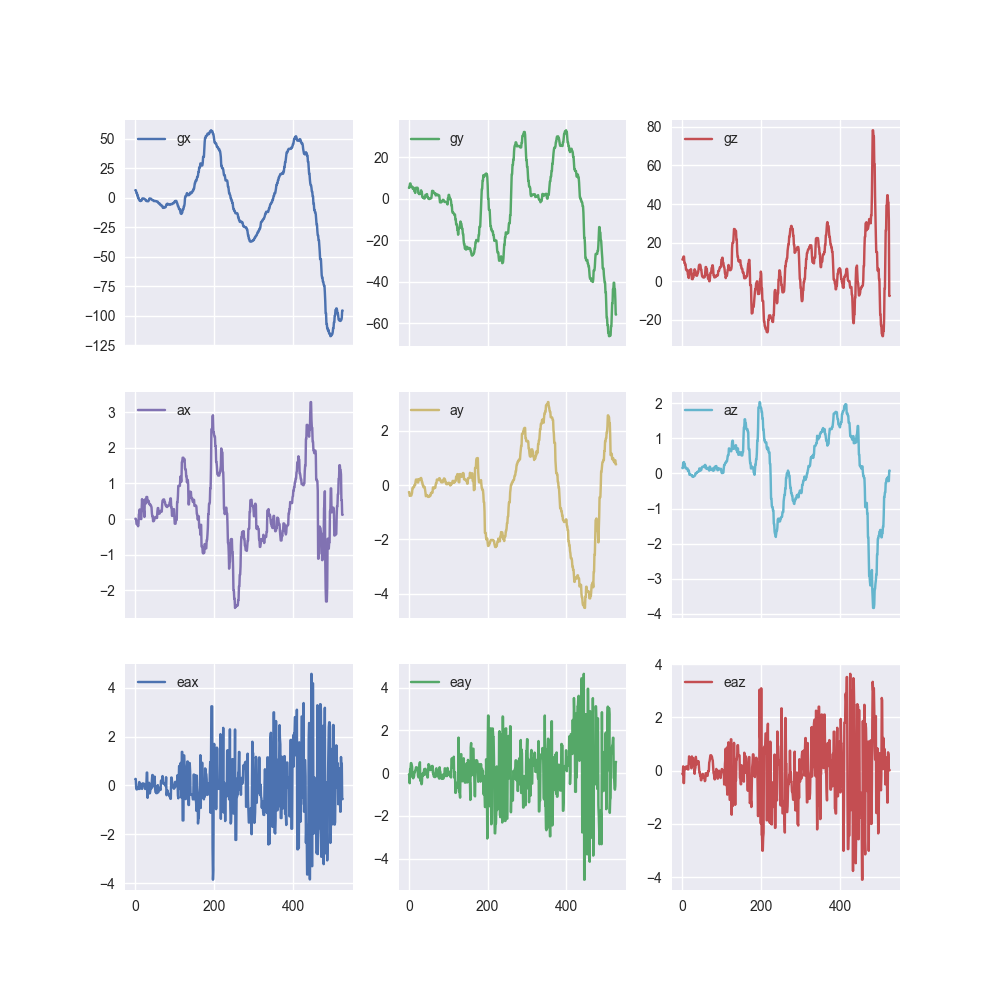

In [270]:
ndf = df
ndf['eax'] = earth_accel[0,:]
ndf['eay'] = earth_accel[1,:]
ndf['eaz'] = earth_accel[2,:]
ndf.drop('clock', axis=1).plot(subplots=True, sharex=True, layout=(3,3), figsize=(10, 10))
plt.show()

In [271]:
ndf

,clock,gx,gy,gz,ax,ay,az,eax,eay,eaz
0,752563007,6.4375,5.3125,11.1875,0.01,-0.26,0.15,0.263730,-0.061515,-0.129855
1,752569404,6.4375,5.3125,11.1875,0.01,-0.26,0.15,0.263730,-0.061515,-0.129855
2,752577018,5.3750,6.2500,12.1875,-0.02,-0.40,0.30,-0.069784,-0.468790,0.160519
3,752584031,3.8125,7.4375,12.7500,-0.14,-0.39,0.32,-0.164696,0.167767,-0.467792
4,752589943,3.8125,7.4375,12.7500,-0.14,-0.39,0.32,-0.164696,0.167767,-0.467792
...,...,...,...,...,...,...,...,...,...,...
522,755678003,-103.3750,-43.6875,40.7500,1.25,0.83,-0.10,1.161113,-0.662691,0.688519
523,755685753,-103.3750,-43.6875,40.7500,0.53,0.91,-0.22,0.439045,-0.770221,0.609425
524,755691786,-101.6250,-48.5625,31.6875,0.53,0.91,-0.22,0.890908,-0.598956,0.070244
525,755718298,-95.5625,-55.8750,-7.6875,0.12,0.76,0.08,-0.563954,0.529354,0.011832


In [277]:
import plotly.express as px
dt=0.0001
edf = pd.DataFrame({
    'x': cumulative_trapezoid(cumulative_trapezoid(ndf['eax'],dx=dt),dx=dt),
    'y': cumulative_trapezoid(cumulative_trapezoid(ndf['eay'],dx=dt),dx=dt),
    'z': cumulative_trapezoid(cumulative_trapezoid(ndf['eaz'],dx=dt),dx=dt),
})


def plot3d(cdf, i, j):
    chart = px.scatter_3d(cdf.loc[i:j:1], x='x', y='y', z='z')
    chart.update_layout(width=1200,height=800)
    chart.show()

In [286]:
freq = np.fft.rfftfreq(edf['x'].size, d=dt)
fft_x = np.fft.rfft(edf['x'])
fft_y = np.fft.rfft(edf['y'])
fft_z = np.fft.rfft(edf['z'])
px.line(y=freq, x=fft_x)

TypeError: Object of type complex is not JSON serializable

TypeError: Object of type complex is not JSON serializable

TypeError: Object of type complex is not JSON serializable

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([(-0.0037184067062569063+0j),
                          (-0.0008431583323874132-0.001932565110495563j),
                          (0.00015715177525172898-0.0011232244739836392j), ...,
                          (9.953956635916918e-06-1.4882895907567464e-07j),
                          (9.953959434019682e-06-8.929842486071712e-08j),
                          (9.953961171398079e-06-2.976476249425557e-08j)], dtype=object),
              'xaxis': 'x',
              'y': array([   0.        ,   19.04761905,   38.0952381 , ..., 4952.38095238,
                          4971.42857143, 4990.47619048]),
 